In [1]:
# Importing the required libraries
# Python
import os
import random
import sys

# Package
import glob 
import keras
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import seaborn as sns
import scipy.io.wavfile
import tensorflow as tf
import pickle
py.init_notebook_mode(connected=True)

# Keras
from keras import regularizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
# from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD

# Sklearn
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

## Rest
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm

# to read audio file  
import soundfile        
input_duration=3

In [2]:
# Reading the data
# Data Directory
dir_list = os.listdir("C:\\Ravdess_data\\")
dir_list.sort()
print (dir_list)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


In [3]:
# Creating a DataFrame 
data_df = pd.DataFrame(columns=['path', 'source', 'actor', 'gender',
                                'intensity', 'statement', 'repetition', 'emotion'])
count = 0
for i in dir_list:
    file_list = os.listdir("C://Ravdess_data//" + i)
    for f in file_list:
        nm = f.split('.')[0].split('-')
        path = "C://Ravdess_data//" + i + '/' + f
        src = int(nm[1])
        actor = int(nm[-1])
        emotion = int(nm[2])
        
        if int(actor)%2 == 0:
            gender = "female"
        else:
            gender = "male"
        
        if nm[3] == '01':
            intensity = 0
        else:
            intensity = 1
        
        if nm[4] == '01':
            statement = 0
        else:
            statement = 1
        
        if nm[5] == '01':
            repeat = 0
        else:
            repeat = 1
            
        data_df.loc[count] = [path, src, actor, gender, intensity, statement, repeat, emotion]
        count += 1

In [4]:
print (len(data_df))
data_df.head()

1440


,path,source,actor,gender,intensity,statement,repetition,emotion
0,C://Ravdess_data//Actor_01/03-01-01-01-01-01-0...,1,1,male,0,0,0,1
1,C://Ravdess_data//Actor_01/03-01-01-01-01-02-0...,1,1,male,0,0,1,1
2,C://Ravdess_data//Actor_01/03-01-01-01-02-01-0...,1,1,male,0,1,0,1
3,C://Ravdess_data//Actor_01/03-01-01-01-02-02-0...,1,1,male,0,1,1,1
4,C://Ravdess_data//Actor_01/03-01-02-01-01-01-0...,1,1,male,0,0,0,2


In [5]:
print(data_df.path[0])


C://Ravdess_data//Actor_01/03-01-01-01-01-01-01.wav


In [6]:
# Plotting the audio file's waveform and its spectrogram

In [7]:
filename = data_df.path[1002]
print (filename)

samples, sample_rate = librosa.load(filename)
sample_rate, samples

C://Ravdess_data//Actor_17/03-01-06-02-02-01-17.wav


(22050,
 array([-2.1325807e-04, -3.1254377e-04, -6.0671537e-05, ...,
         2.0387740e-04,  2.0894772e-04,  2.3353650e-04], dtype=float32))

In [8]:
len(samples), sample_rate

(80931, 22050)

In [9]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [10]:
sample_rate/ len(samples)


0.2724543129332394

Text(0.5, 0, 'Seconds')

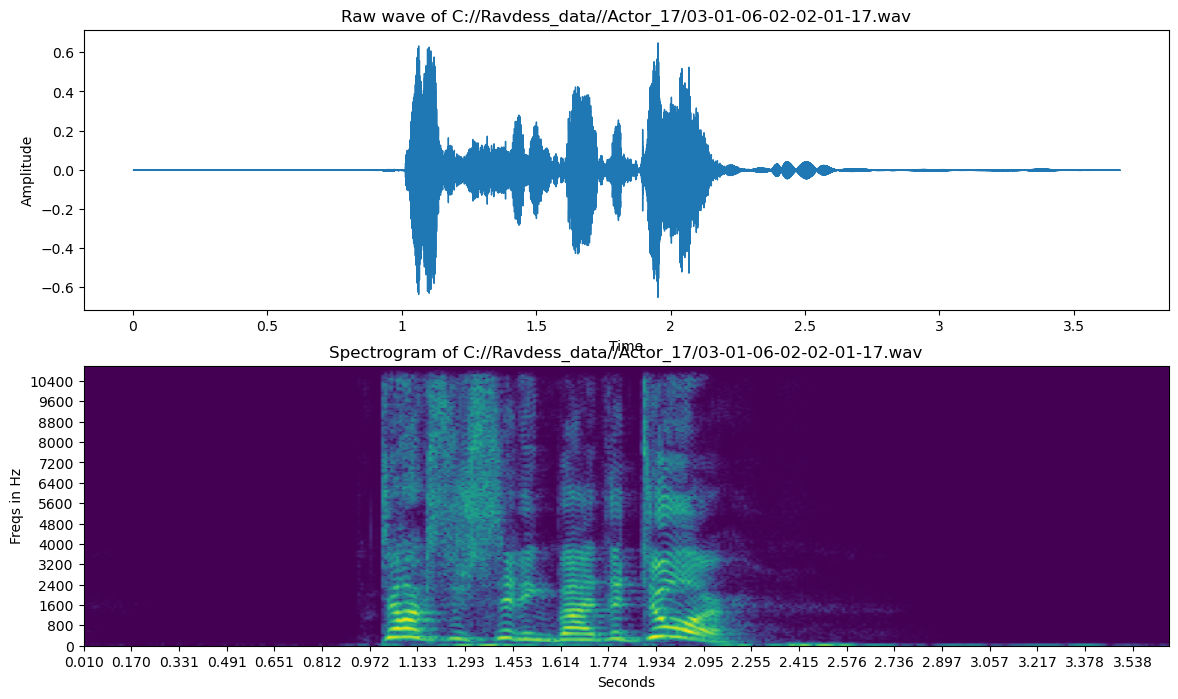

In [11]:
# Plotting Wave Form and Spectrogram
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
librosa.display.waveshow(samples, sr=sample_rate)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [12]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std

In [13]:
# Trim the silence voice
aa , bb = librosa.effects.trim(samples, top_db=30)
aa, bb

(array([0.0006732 , 0.00075487, 0.00070904, ..., 0.00355441, 0.00333081,
        0.00305546], dtype=float32),
 array([21504, 58368]))

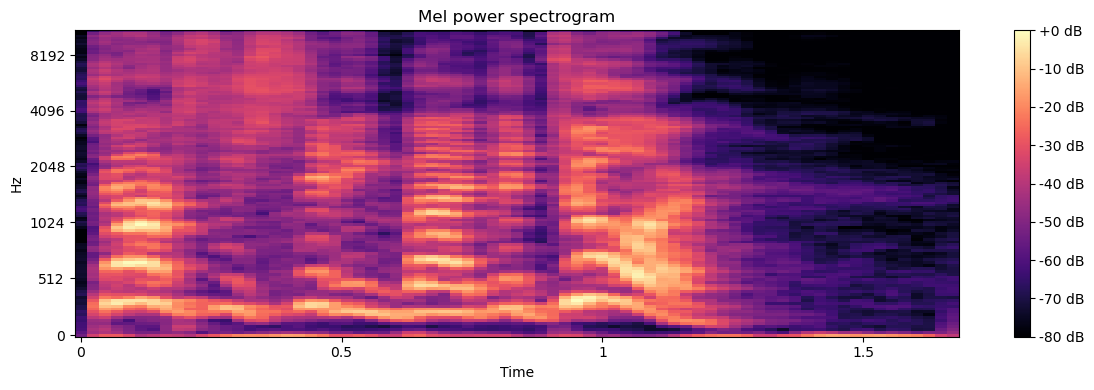

In [14]:
# Plotting Mel Power Spectrogram
S = librosa.feature.melspectrogram(y=aa, sr=sample_rate, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)
plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()


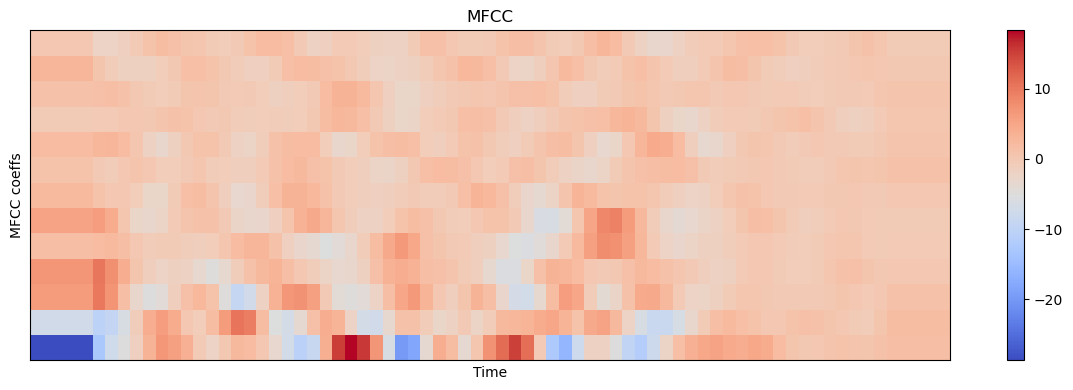

In [15]:
# Plotting MFCC
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)
plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

In [16]:
# Original Sound
ipd.Audio(samples, rate=sample_rate)

In [17]:
# Silence trimmed Sound by librosa.effects.trim()
ipd.Audio(aa, rate=sample_rate)

In [18]:
# Silence trimmed Sound by manuel trimming
samples_cut = samples[10000:-12500]
ipd.Audio(samples_cut, rate=sample_rate)

In [19]:
# Defining the truth label

In [20]:
# 2 classes: Positive & Negative
# Positive: Calm, Happy
# Negative: Angry, Fearful, Sad

label2_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 2: # Calm
        lb = "_positive"
    elif data_df.emotion[i] == 3: # Happy
        lb = "_positive"
    elif data_df.emotion[i] == 4: # Sad
        lb = "_negative"
    elif data_df.emotion[i] == 5: # Angry
        lb = "_negative"
    elif data_df.emotion[i] == 6: # Fearful
        lb = "_negative"
    else:
        lb = "_none"
        
    # Add gender to the label    
    label2_list.append(data_df.gender[i] + lb)
    
len(label2_list)

1440

In [21]:
#3 classes: Positive, Neutral & Negative
# Positive:  Happy
# Negative: Angry, Fearful, Sad
# Neutral: Calm, Neutral

label3_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 1: # Neutral
        lb = "_neutral"
    elif data_df.emotion[i] == 2: # Calm
        lb = "_neutral"
    elif data_df.emotion[i] == 3: # Happy
        lb = "_positive"
    elif data_df.emotion[i] == 4: # Sad
        lb = "_negative"
    elif data_df.emotion[i] == 5: # Angry
        lb = "_negative"
    elif data_df.emotion[i] == 6: # Fearful
        lb = "_negative"
    else:
        lb = "_none"
    
    # Add gender to the label  
    label3_list.append(data_df.gender[i] + lb)
    
len(label3_list)

1440

In [22]:
# 5 classes: angry, calm, sad, happy & fearful
label5_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 2:
        lb = "_calm"
    elif data_df.emotion[i] == 3:
        lb = "_happy"
    elif data_df.emotion[i] == 4:
        lb = "_sad"
    elif data_df.emotion[i] == 5:
        lb = "_angry"
    elif data_df.emotion[i] == 6:
        lb = "_fearful"    
    else:
        lb = "_none"
    
    # Add gender to the label  
    label5_list.append(data_df.gender[i] + lb)
    
len(label5_list)

1440

In [23]:
# All classes

label8_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 1:
        lb = "_neutral"
    elif data_df.emotion[i] == 2:
        lb = "_calm"
    elif data_df.emotion[i] == 3:
        lb = "_happy"
    elif data_df.emotion[i] == 4:
        lb = "_sad"
    elif data_df.emotion[i] == 5:
        lb = "_angry"
    elif data_df.emotion[i] == 6:
        lb = "_fearful"
    elif data_df.emotion[i] == 7:
        lb = "_disgust"
    elif data_df.emotion[i] == 8:
        lb = "_surprised"
    else:
        lb = "_none"
        
    # Add gender to the label 
    label8_list.append(data_df.gender[i]  + lb)
    
len(label8_list)

1440

In [24]:
# Select the label set you want by commenting the unwanteds.

data_df['label'] = label2_list
data_df.head()

,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,C://Ravdess_data//Actor_01/03-01-01-01-01-01-0...,1,1,male,0,0,0,1,male_none
1,C://Ravdess_data//Actor_01/03-01-01-01-01-02-0...,1,1,male,0,0,1,1,male_none
2,C://Ravdess_data//Actor_01/03-01-01-01-02-01-0...,1,1,male,0,1,0,1,male_none
3,C://Ravdess_data//Actor_01/03-01-01-01-02-02-0...,1,1,male,0,1,1,1,male_none
4,C://Ravdess_data//Actor_01/03-01-02-01-01-01-0...,1,1,male,0,0,0,2,male_positive


In [25]:
print (data_df.label.value_counts().keys())


Index(['male_negative', 'female_negative', 'male_none', 'female_none',
       'male_positive', 'female_positive'],
      dtype='object', name='label')


In [26]:
# Plotting the emotion distribution

def plot_emotion_dist(dist, color_code='#C2185B', title="Plot"):
    """
    To plot the data distributioin by class.
    Arg:
      dist: pandas series of label count. 
    """
    tmp_df = pd.DataFrame()
    tmp_df['Emotion'] = list(dist.keys())
    tmp_df['Count'] = list(dist)
    fig, ax = plt.subplots(figsize=(14, 7))
    ax = sns.barplot(x="Emotion", y='Count', color=color_code, data=tmp_df)
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

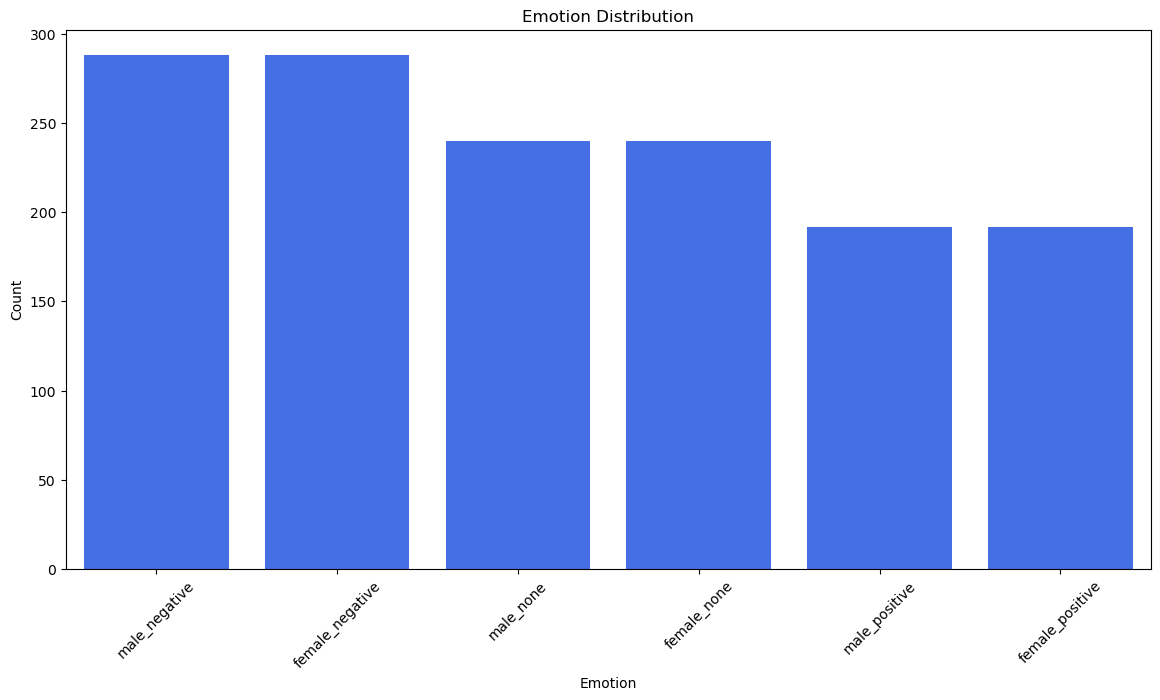

In [27]:
a = data_df.label.value_counts()
plot_emotion_dist(a, "#2962FF", "Emotion Distribution")

In [28]:
# Data Splitting

In [29]:
# Male Data Set

data2_df = data_df.copy()
data2_df = data2_df[data2_df.label != "male_none"]
data2_df = data2_df[data2_df.label != "female_none"].reset_index(drop=True)
data2_df = data2_df[data2_df.label != "female_neutral"]
data2_df = data2_df[data2_df.label != "female_happy"]
data2_df = data2_df[data2_df.label != "female_angry"]
data2_df = data2_df[data2_df.label != "female_sad"]
data2_df = data2_df[data2_df.label != "female_fearful"]
data2_df = data2_df[data2_df.label != "female_calm"]
data2_df = data2_df[data2_df.label != "female_positive"]
data2_df = data2_df[data2_df.label != "female_negative"].reset_index(drop=True)

tmp1 = data2_df[data2_df.actor == 21]
tmp2 = data2_df[data2_df.actor == 22]
tmp3 = data2_df[data2_df.actor == 23]
tmp4 = data2_df[data2_df.actor == 24]
data3_df = pd.concat([tmp1, tmp3],ignore_index=True).reset_index(drop=True)
data2_df = data2_df[data2_df.actor != 21]
data2_df = data2_df[data2_df.actor != 22]
data2_df = data2_df[data2_df.actor != 23].reset_index(drop=True)
data2_df = data2_df[data2_df.actor != 24].reset_index(drop=True)
print (len(data2_df))
data2_df.head()

400


,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,C://Ravdess_data//Actor_01/03-01-02-01-01-01-0...,1,1,male,0,0,0,2,male_positive
1,C://Ravdess_data//Actor_01/03-01-02-01-01-02-0...,1,1,male,0,0,1,2,male_positive
2,C://Ravdess_data//Actor_01/03-01-02-01-02-01-0...,1,1,male,0,1,0,2,male_positive
3,C://Ravdess_data//Actor_01/03-01-02-01-02-02-0...,1,1,male,0,1,1,2,male_positive
4,C://Ravdess_data//Actor_01/03-01-02-02-01-01-0...,1,1,male,1,0,0,2,male_positive


In [30]:
print (len(data3_df))
data3_df.head()

80


,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,C://Ravdess_data//Actor_21/03-01-02-01-01-01-2...,1,21,male,0,0,0,2,male_positive
1,C://Ravdess_data//Actor_21/03-01-02-01-01-02-2...,1,21,male,0,0,1,2,male_positive
2,C://Ravdess_data//Actor_21/03-01-02-01-02-01-2...,1,21,male,0,1,0,2,male_positive
3,C://Ravdess_data//Actor_21/03-01-02-01-02-02-2...,1,21,male,0,1,1,2,male_positive
4,C://Ravdess_data//Actor_21/03-01-02-02-01-01-2...,1,21,male,1,0,0,2,male_positive


In [31]:
# Getting the features of audio files using librosa

In [32]:
import resampy

In [33]:
data = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
#     X = X[10000:90000]
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data.loc[i] = [feature]

100%|██████████| 400/400 [00:31<00:00, 12.81it/s]


In [34]:
data.head()


,feature
0,"[-70.26808, -70.26808, -70.26808, -70.26808, -..."
1,"[-67.55767, -67.55767, -67.55767, -67.55767, -..."
2,"[-69.69336, -69.69336, -69.69336, -69.69336, -..."
3,"[-69.051476, -69.051476, -69.051476, -69.05147..."
4,"[-73.84186, -73.84186, -73.84186, -73.72008, -..."


In [35]:
df3 = pd.DataFrame(data['feature'].values.tolist())
labels = data2_df.label

In [36]:
df3.head()


,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,256,257,258
0,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,...,-70.268082,-70.268082,-69.958099,-68.378006,-69.862946,-70.268082,-70.122566,-68.555412,-70.206917,-70.268082
1,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-65.240265,-65.536674,-67.557671,-67.557671,...,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.127472,-67.557671
2,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.620888,-69.693359,-68.906807,...,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.383789,-69.693359,-69.693359,-69.693359,-69.693359
3,-69.051476,-69.051476,-69.051476,-69.051476,-69.051476,-68.755074,-69.051476,-69.051476,-69.051476,-68.359322,...,-65.447311,-68.552307,-69.051476,-69.051476,-69.051476,-68.688873,-69.051476,NaN,NaN,NaN
4,-73.841858,-73.841858,-73.841858,-73.720078,-73.841858,-73.841858,-73.841858,-73.304192,-72.807358,-73.841858,...,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858


In [37]:
newdf = pd.concat([df3,labels], axis=1)


In [38]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})
len(rnewdf)

400

In [39]:
rnewdf.head(10)


,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,...,-70.268082,-69.958099,-68.378006,-69.862946,-70.268082,-70.122566,-68.555412,-70.206917,-70.268082,male_positive
1,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-65.240265,-65.536674,-67.557671,-67.557671,...,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.127472,-67.557671,male_positive
2,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.620888,-69.693359,-68.906807,...,-69.693359,-69.693359,-69.693359,-69.693359,-69.383789,-69.693359,-69.693359,-69.693359,-69.693359,male_positive
3,-69.051476,-69.051476,-69.051476,-69.051476,-69.051476,-68.755074,-69.051476,-69.051476,-69.051476,-68.359322,...,-68.552307,-69.051476,-69.051476,-69.051476,-68.688873,-69.051476,NaN,NaN,NaN,male_positive
4,-73.841858,-73.841858,-73.841858,-73.720078,-73.841858,-73.841858,-73.841858,-73.304192,-72.807358,-73.841858,...,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,male_positive
5,-69.243607,-69.243607,-69.243607,-69.243607,-68.902374,-67.983444,-68.089653,-67.897789,-65.258499,-67.171410,...,-57.186440,-61.189224,-67.108902,-67.508621,-66.246048,-68.733475,-69.243607,-69.243607,-69.243607,male_positive
6,-73.255318,-73.255318,-73.255318,-73.255318,-68.774933,-69.380905,-73.255318,-73.255318,-73.255318,-73.255318,...,-50.886684,-55.668213,-54.602642,-53.441685,-56.299820,-57.457932,-58.767605,-59.844353,-59.074680,male_positive
7,-70.746674,-70.746674,-70.025597,-69.131645,-70.746674,-70.746674,-70.746674,-70.746674,-70.746674,-70.746674,...,-70.746674,-70.746674,-70.079544,-69.590736,-69.203033,-70.159676,-70.445572,-68.199638,-67.593987,male_positive
8,-63.787254,-63.128746,-63.412743,-63.797016,-63.582291,-58.921696,-57.955513,-61.225422,-63.783241,-63.797016,...,-63.740913,-62.410637,-62.489479,-62.494827,-62.633003,-62.878506,NaN,NaN,NaN,male_positive
9,-60.981300,-60.116249,-60.978966,-60.952496,-60.982536,-60.983990,-60.981300,-60.981300,-60.981300,-60.249794,...,-60.981300,-60.981300,-60.981300,-60.981300,-60.981300,-60.981300,NaN,NaN,NaN,male_positive


In [40]:
rnewdf.isnull().sum().sum()


2284

In [41]:
rnewdf = rnewdf.fillna(0)
rnewdf.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,...,-70.268082,-69.958099,-68.378006,-69.862946,-70.268082,-70.122566,-68.555412,-70.206917,-70.268082,male_positive
1,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-65.240265,-65.536674,-67.557671,-67.557671,...,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.127472,-67.557671,male_positive
2,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.620888,-69.693359,-68.906807,...,-69.693359,-69.693359,-69.693359,-69.693359,-69.383789,-69.693359,-69.693359,-69.693359,-69.693359,male_positive
3,-69.051476,-69.051476,-69.051476,-69.051476,-69.051476,-68.755074,-69.051476,-69.051476,-69.051476,-68.359322,...,-68.552307,-69.051476,-69.051476,-69.051476,-68.688873,-69.051476,0.000000,0.000000,0.000000,male_positive
4,-73.841858,-73.841858,-73.841858,-73.720078,-73.841858,-73.841858,-73.841858,-73.304192,-72.807358,-73.841858,...,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,male_positive


In [42]:
# Data Augmentation

In [43]:
def plot_time_series(data):
    """
    Plot the Audio Frequency.
    """
    fig = plt.figure(figsize=(14, 8))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 1, len(data)), data)
    plt.show()


def noise(data):
    """
    Adding White Noise.
    """
    # you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
    noise_amp = 0.005*np.random.uniform()*np.amax(data)
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data
    
def shift(data):
    """
    Random Shifting.
    """
    s_range = int(np.random.uniform(low=-5, high = 5)*500)
    return np.roll(data, s_range)
    
def stretch(data, rate=0.8):
    """
    Streching the Sound.
    """
    data = librosa.effects.time_stretch(data, rate)
    return data
    
def pitch(data, sample_rate):
    """
    Pitch Tuning.
    """
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change = pitch_pm * 2 * (np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                       n_steps=pitch_change, 
                                       sr=sample_rate,
                                       bins_per_octave=bins_per_octave)
    return data
    
def dyn_change(data):
    """
    Random Value Change.
    """
    dyn_change = np.random.uniform(low=1.5,high=3)
    return (data * dyn_change)
    
def speedNpitch(data):
    """
    peed and Pitch Tuning.
    """
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.0  / length_change
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data

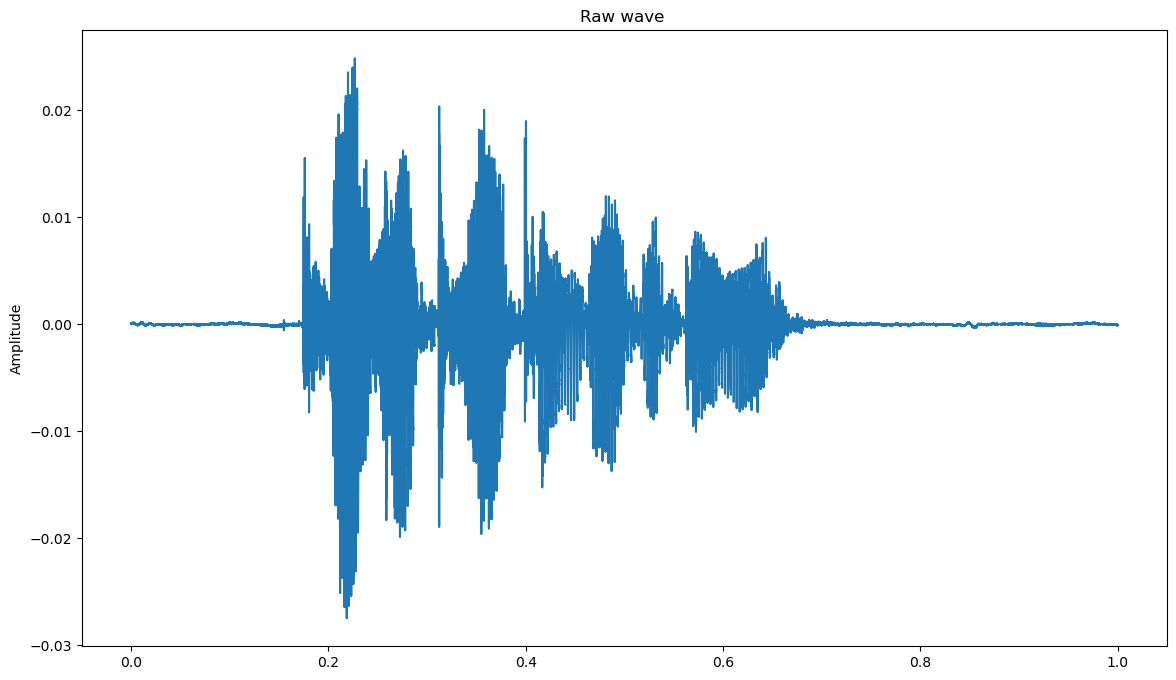

In [44]:
X, sample_rate = librosa.load(data2_df.path[216], res_type='kaiser_fast',duration=4,sr=22050*2,offset=0.5)
plot_time_series(X)
ipd.Audio(X, rate=sample_rate)

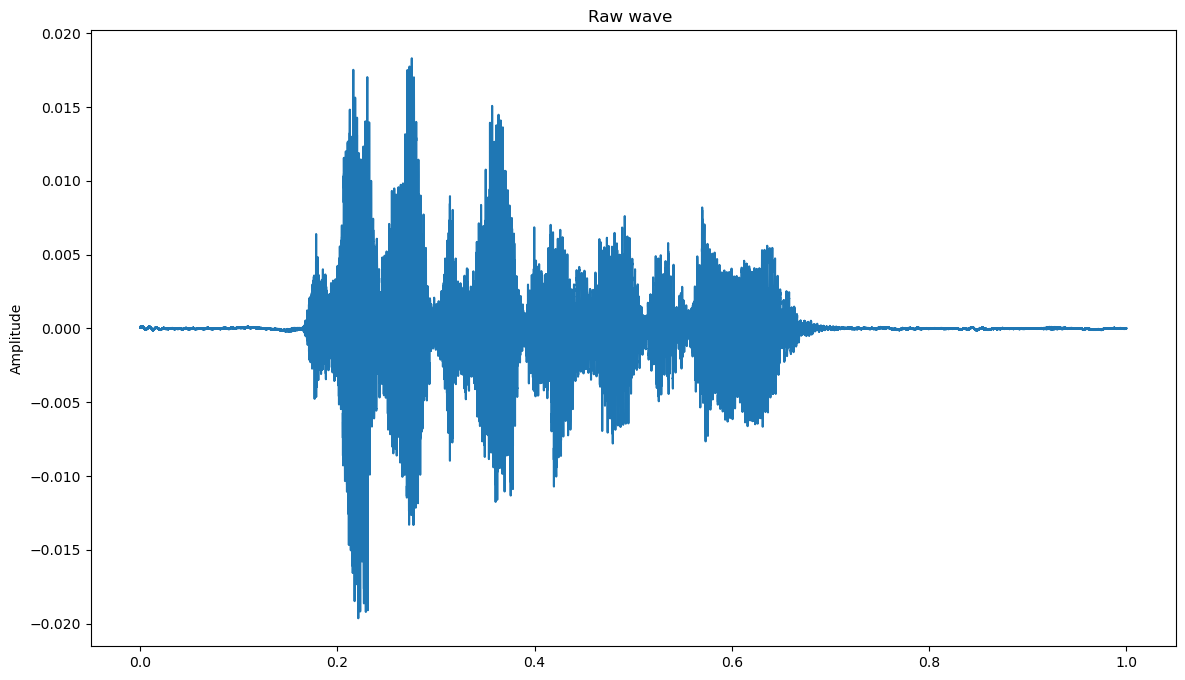

In [45]:
x = pitch(X, sample_rate)
plot_time_series(x)
ipd.Audio(x, rate=sample_rate)

In [46]:
# Augmentation Method 1

syn_data1 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data2_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = noise(X)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data1.loc[i] = [feature, data2_df.label[i]]

100%|██████████| 400/400 [00:35<00:00, 11.34it/s]


In [47]:
# Augmentation Method 2

syn_data2 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data2_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = pitch(X, sample_rate)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data2.loc[i] = [feature, data2_df.label[i]]

100%|██████████| 400/400 [01:19<00:00,  5.03it/s]


In [48]:
len(syn_data1), len(syn_data2) 


(400, 400)

In [49]:
syn_data1 = syn_data1.reset_index(drop=True)
syn_data2 = syn_data2.reset_index(drop=True)

In [50]:
df4 = pd.DataFrame(syn_data1['feature'].values.tolist())
labels4 = syn_data1.label
syndf1 = pd.concat([df4,labels4], axis=1)
syndf1 = syndf1.rename(index=str, columns={"0": "label"})
syndf1 = syndf1.fillna(0)
len(syndf1)

400

In [51]:
syndf1.head()


,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-61.719551,-56.273767,-55.798771,-56.083159,-56.035708,-56.369574,-57.083957,-57.245726,-55.138954,-53.663401,...,-56.968292,-55.695084,-52.994035,-54.838963,-57.498319,-56.307454,-56.296123,-57.589299,-56.696912,male_positive
1,-62.013191,-60.103129,-60.425227,-59.435714,-61.966227,-62.655782,-61.067121,-60.233511,-57.958579,-60.349148,...,-61.271641,-64.748723,-61.604381,-59.681024,-60.979327,-62.526488,-60.841081,-61.563871,-62.067419,male_positive
2,-60.819524,-59.453478,-58.060613,-56.734604,-58.298751,-58.322520,-56.979156,-57.657521,-60.875057,-61.667367,...,-60.631190,-58.625503,-57.374992,-59.865046,-60.524959,-61.721066,-60.209966,-58.731005,-59.565540,male_positive
3,-56.793009,-53.270918,-53.366278,-51.802071,-53.070565,-55.030587,-55.036942,-54.087760,-53.633592,-54.886537,...,-55.356277,-54.515336,-54.608322,-53.823172,-53.270756,-54.984755,0.000000,0.000000,0.000000,male_positive
4,-67.343034,-62.437804,-62.741822,-61.608666,-61.476204,-62.675595,-65.724604,-62.677343,-60.188789,-62.164600,...,-63.259186,-62.779267,-60.772861,-61.932335,-63.503034,-62.924445,-63.154536,-63.896742,-67.120969,male_positive


In [52]:
df4 = pd.DataFrame(syn_data2['feature'].values.tolist())
labels4 = syn_data2.label
syndf2 = pd.concat([df4,labels4], axis=1)
syndf2 = syndf2.rename(index=str, columns={"0": "label"})
syndf2 = syndf2.fillna(0)
len(syndf2)

400

In [53]:
syndf2.head()


,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-73.364159,-73.364159,-73.364159,-73.364159,-73.364159,-73.364159,-73.364159,-73.364159,-73.364159,-73.364159,...,-73.364159,-73.347434,-71.889703,-72.082596,-73.364159,-73.103327,-71.616493,-72.879645,-73.364159,male_positive
1,-70.814466,-70.621923,-70.783356,-70.814466,-70.814466,-70.814466,-67.861009,-66.685555,-70.814466,-70.814466,...,-70.814466,-70.814466,-70.814466,-70.814466,-70.814466,-70.814466,-70.814466,-70.814466,-70.814466,male_positive
2,-71.265137,-71.265137,-71.265137,-71.265137,-71.265137,-71.265137,-71.265137,-71.265137,-71.265137,-70.001901,...,-71.265137,-71.265137,-71.265137,-71.265137,-71.265137,-71.265137,-71.265137,-71.265137,-71.265137,male_positive
3,-69.693902,-69.693902,-69.693902,-69.693902,-69.693902,-69.693902,-69.693902,-69.693902,-69.693902,-69.117935,...,-69.444644,-69.693902,-69.693902,-69.693902,-69.693902,-69.693902,0.000000,0.000000,0.000000,male_positive
4,-73.463951,-73.463951,-73.463951,-73.410666,-73.463951,-73.463951,-73.463951,-73.463709,-72.983543,-73.463951,...,-73.463951,-73.463951,-73.463951,-73.463951,-73.463951,-73.463951,-73.463951,-73.463951,-73.463951,male_positive


In [54]:
# Combining the Augmented data with original
combined_df = pd.concat([rnewdf, syndf1, syndf2], ignore_index=True)
combined_df = combined_df.fillna(0)
combined_df.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,...,-70.268082,-69.958099,-68.378006,-69.862946,-70.268082,-70.122566,-68.555412,-70.206917,-70.268082,male_positive
1,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-65.240265,-65.536674,-67.557671,-67.557671,...,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.127472,-67.557671,male_positive
2,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.620888,-69.693359,-68.906807,...,-69.693359,-69.693359,-69.693359,-69.693359,-69.383789,-69.693359,-69.693359,-69.693359,-69.693359,male_positive
3,-69.051476,-69.051476,-69.051476,-69.051476,-69.051476,-68.755074,-69.051476,-69.051476,-69.051476,-68.359322,...,-68.552307,-69.051476,-69.051476,-69.051476,-68.688873,-69.051476,0.000000,0.000000,0.000000,male_positive
4,-73.841858,-73.841858,-73.841858,-73.720078,-73.841858,-73.841858,-73.841858,-73.304192,-72.807358,-73.841858,...,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,male_positive


In [55]:
#  Stratified Shuffle Split

X = combined_df.drop(['label'], axis=1)
y = combined_df.label
xxx = StratifiedShuffleSplit(1, test_size=0.2, random_state=12)
for train_index, test_index in xxx.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [56]:
y_train.value_counts()

label
male_negative    576
male_positive    384
Name: count, dtype: int64

In [57]:
y_test.value_counts()

label
male_negative    144
male_positive     96
Name: count, dtype: int64

In [58]:
X_train.isna().sum().sum()

0

In [59]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))

In [60]:
y_train


array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [61]:
X_train.shape


(960, 259)

In [62]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [63]:
# Set up Keras util functions

from keras import backend as K

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = (K.sum(K.round(K.clip(y_true, 0, 1))))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fscore(y_true, y_pred):
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0.0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f_score = 2 * (p * r) / (p + r + K.epsilon())
    return float(f_score)

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

In [66]:
model = Sequential()
model.add(Conv1D(256, 8, padding='same', input_shape=(X_train.shape[1], 1)))
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
# Edit according to target class no.
model.add(Dense(2))
model.add(Activation('softmax'))

# Use the new learning rate schedule instead of decay
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.0001,
                                                              decay_steps=10000,
                                                              decay_rate=0.9)
opt = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.0, nesterov=False)

In [67]:
# Plotting Model Summary

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 259, 256)          2304      
                                                                 
 activation_9 (Activation)   (None, 259, 256)          0         
                                                                 
 conv1d_9 (Conv1D)           (None, 259, 256)          524544    
                                                                 
 batch_normalization_2 (Bat  (None, 259, 256)          1024      
 chNormalization)                                                
                                                                 
 activation_10 (Activation)  (None, 259, 256)          0         
                                                                 
 dropout_2 (Dropout)         (None, 259, 256)          0         
                                                      

In [68]:
# Compiling model

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', fscore])

In [69]:
# Removed the whole training part for avoiding unnecessary long epochs list

In [70]:
# Model Training
import tensorflow
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
mcp_save = ModelCheckpoint('model/aug_noiseNshift_2class2_np.h5', save_best_only=True, monitor='val_loss', mode='min')
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=25,
                     validation_data=(x_testcnn, y_test), callbacks=[mcp_save, lr_reduce])


Epoch 1/25


60/60 [==============================] - 12s 144ms/step - loss: 0.7056 - accuracy: 0.5969 - fscore: 0.5969 - val_loss: 0.6880 - val_accuracy: 0.5917 - val_fscore: 0.5917 - lr: 9.9938e-05
Epoch 2/25


C:\Users\abhil\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



60/60 [==============================] - 7s 125ms/step - loss: 0.6622 - accuracy: 0.5927 - fscore: 0.5927 - val_loss: 0.6862 - val_accuracy: 0.5917 - val_fscore: 0.5917 - lr: 9.9875e-05
Epoch 3/25
60/60 [==============================] - 8s 129ms/step - loss: 0.6496 - accuracy: 0.6125 - fscore: 0.6125 - val_loss: 0.6769 - val_accuracy: 0.6250 - val_fscore: 0.6250 - lr: 9.9812e-05
Epoch 4/25
60/60 [==============================] - 7s 125ms/step - loss: 0.6331 - accuracy: 0.6177 - fscore: 0.6177 - val_loss: 0.6646 - val_accuracy: 0.6292 - val_fscore: 0.6292 - lr: 9.9749e-05
Epoch 5/25
60/60 [==============================] - 8s 132ms/step - loss: 0.6210 - accuracy: 0.6490 - fscore: 0.6490 - val_loss: 0.6508 - val_accuracy: 0.6250 - val_fscore: 0.6250 - lr: 9.9685e-05
Epoch 6/25
60/60 [==============================] - 8s 127ms/step - loss: 0.6211 - accuracy: 0.6406 - fscore: 0.6406 - val_loss: 0.6371 - val_accuracy: 0.6500 - val_fscore: 0.6500 - lr: 9.9622e-05
Epoch 7/25
60/60 [========

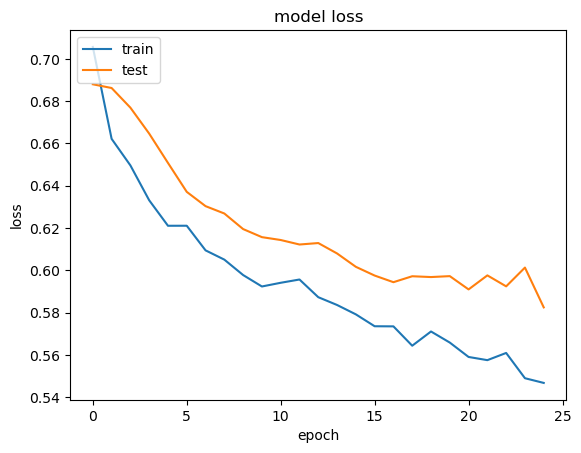

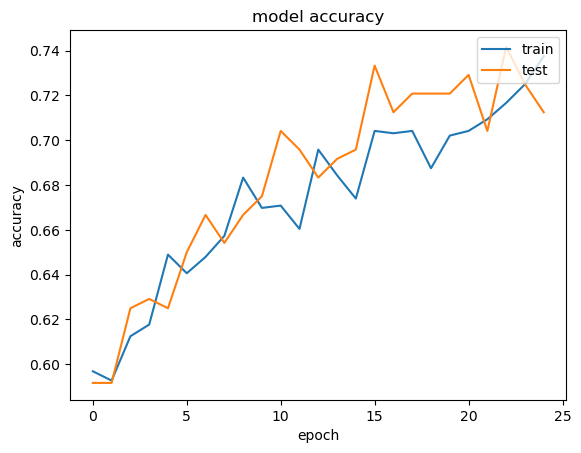

In [71]:
# Plotting the Train Valid Loss Graph & accuracy graph

plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [72]:
# Saving the model.json

import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [73]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("model/aug_noiseNshift_2class2_np.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 71.25%


In [74]:
# Predicting emotions on the test data

In [75]:
len(data3_df)


80

In [76]:
data_test = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data3_df))):
    X, sample_rate = librosa.load(data3_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
#     X = X[10000:90000]
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data_test.loc[i] = [feature]
    
test_valid = pd.DataFrame(data_test['feature'].values.tolist())
test_valid = np.array(test_valid)
test_valid_lb = np.array(data3_df.label)
lb = LabelEncoder()
test_valid_lb = to_categorical(lb.fit_transform(test_valid_lb))
test_valid = np.expand_dims(test_valid, axis=2)

100%|██████████| 80/80 [00:06<00:00, 12.79it/s]


In [77]:
preds = loaded_model.predict(test_valid, 
                         batch_size=16, 
                         verbose=1)

5/5 [==============================] - 1s 33ms/step


In [78]:
preds


array([[0.43025547, 0.5697446 ],
       [0.4302074 , 0.5697926 ],
       [0.49777886, 0.5022211 ],
       [0.3766991 , 0.6233009 ],
       [0.39185783, 0.6081422 ],
       [0.4330141 , 0.5669859 ],
       [0.39945403, 0.600546  ],
       [0.3553039 , 0.644696  ],
       [0.38890463, 0.6110954 ],
       [0.4982118 , 0.50178814],
       [0.525791  , 0.47420904],
       [0.44023356, 0.5597664 ],
       [0.5286394 , 0.47136068],
       [0.6019506 , 0.39804944],
       [0.6017036 , 0.3982964 ],
       [0.5771453 , 0.42285475],
       [0.41151017, 0.58848983],
       [0.4222143 , 0.57778573],
       [0.34319893, 0.65680104],
       [0.27897832, 0.7210217 ],
       [0.4353045 , 0.5646956 ],
       [0.34472176, 0.6552782 ],
       [0.3538251 , 0.6461749 ],
       [0.39139986, 0.60860014],
       [0.6281823 , 0.37181768],
       [0.6774168 , 0.32258317],
       [0.73500806, 0.26499197],
       [0.7375077 , 0.2624923 ],
       [0.7468736 , 0.25312644],
       [0.7394214 , 0.26057857],
       [0.

In [79]:
preds1=preds.argmax(axis=1)
preds1

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [80]:
abc = preds1.astype(int).flatten()

In [81]:
predictions = (lb.inverse_transform((abc)))

In [82]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,male_positive
1,male_positive
2,male_positive
3,male_positive
4,male_positive
5,male_positive
6,male_positive
7,male_positive
8,male_positive
9,male_positive


In [83]:
actual=test_valid_lb.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [84]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,male_positive
1,male_positive
2,male_positive
3,male_positive
4,male_positive
5,male_positive
6,male_positive
7,male_positive
8,male_positive
9,male_positive


In [85]:
finaldf = actualdf.join(preddf)


In [86]:
# Actual v/s Predicted emotions

In [87]:
finaldf[20:40]

,actualvalues,predictedvalues
20,male_negative,male_positive
21,male_negative,male_positive
22,male_negative,male_positive
23,male_negative,male_positive
24,male_negative,male_negative
25,male_negative,male_negative
26,male_negative,male_negative
27,male_negative,male_negative
28,male_negative,male_negative
29,male_negative,male_negative


In [88]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
male_negative,48
male_positive,32


In [89]:
finaldf.groupby('predictedvalues').count()


,actualvalues
predictedvalues,
male_negative,48
male_positive,32


In [90]:
finaldf.to_csv('Predictions.csv', index=False)


In [91]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [92]:
from sklearn.metrics import accuracy_score
y_true = finaldf.actualvalues
y_pred = finaldf.predictedvalues
accuracy_score(y_true, y_pred)*100

67.5

In [93]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred, average='macro') *100

66.14583333333333

In [94]:
from sklearn.metrics import confusion_matrix
c = confusion_matrix(y_true, y_pred)
c

array([[35, 13],
       [13, 19]], dtype=int64)

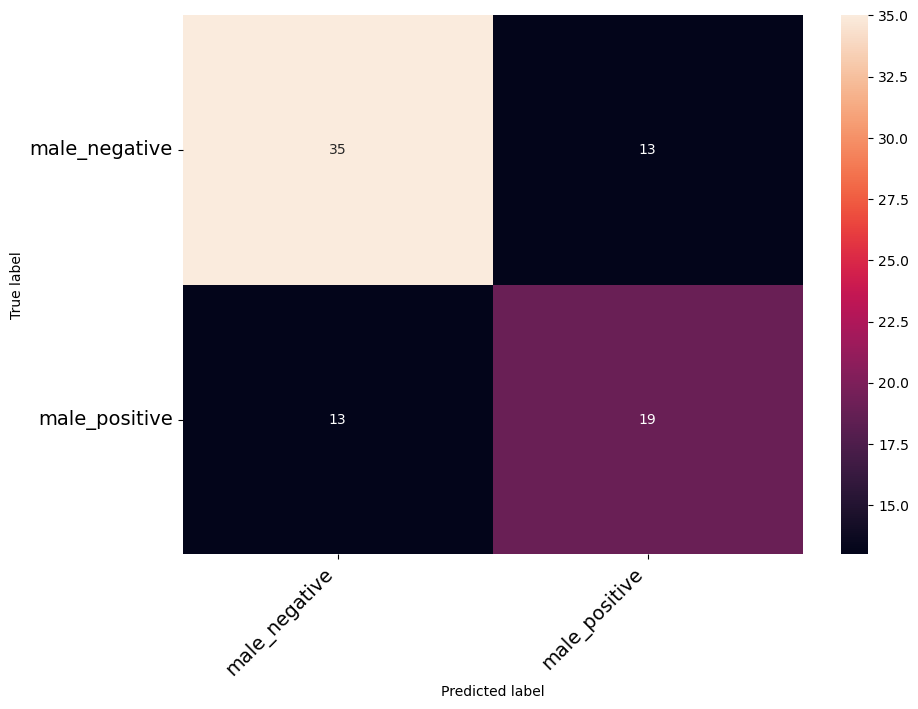

In [95]:
# Visualize Confusion Matrix 

class_names = ['male_negative', 'male_positive']
# class_names = ['female_angry', 'female_calm', 'female_fearful', 'female_happy', 'female_sad', 'male_angry', 'male_calm', 'male_fearful', 'male_happy', 'male_sad']


print_confusion_matrix(c, class_names)

In [96]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from playsound import playsound
import warnings

In [97]:
#Extract features (mfcc, chroma, mel) from a sound file

def extract_feature(file_name, mfcc, chroma, mel):
    X, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    stft = np.abs(librosa.stft(X))

    result = []

    if mfcc:
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        result.append(mfccs)

    if chroma:
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
        result.append(chroma)

    if mel:
        mel = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T, axis=0)
        result.append(mel)

    return np.concatenate(result, axis=None)


In [98]:
# Emotions in the RAVDESS dataset
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

#Emotions to observe
observed_emotions=['calm', 'happy', 'fearful', 'disgust','angry','sad','surprised','neutral']

def get_user_feat():
    print("Which Feature Extraction Processes do you want to apply: ")
    print("1. MFCC \n2. MEL \n3. Chroma \n")
    fext_userinp = input("Enter your options(e.g. 23): ")
    print("Processing. Please wait.....")
    mel = False;
    mfcc = False;
    chroma = False
    for i in range(0, len(fext_userinp)):
        if fext_userinp[i] == "1":
            mfcc = True
        elif fext_userinp[i] == "2":
            mel = True
        elif fext_userinp[i] == "3":
            chroma = True
    return mfcc,mel,chroma


In [99]:
#Load the data and extract features for each sound file
mfcc,mel,chroma = get_user_feat()
def load_data(test_size=0.25):
    x,y=[],[]
    warnings.filterwarnings("ignore")
    for file in glob.glob("C://ravdess_data//Actor_*//*.wav"):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue
        feature=extract_feature(file, mfcc, chroma, mel)
        x.append(feature)
        y.append(emotion)
    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

#Split the dataset
x_train,x_test,y_train,y_test=load_data(test_size=0.25)

x_train

#Get the shape of the training and testing datasets
print((x_train.shape[0], x_test.shape[0]))

#Get the number of features extracted
print(f'Features extracted: {x_train.shape[1]}')

Which Feature Extraction Processes do you want to apply: 
1. MFCC 
2. MEL 
3. Chroma 

Enter your options(e.g. 23): 1
Processing. Please wait.....
(1080, 360)
Features extracted: 40


In [100]:
#Initialize the Multi Layer Perceptron Classifier
model=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

#Train the model
model.fit(x_train,y_train)

#Predict for the test set
y_pred=model.predict(x_test)

y_pred

from sklearn.metrics import accuracy_score, f1_score

f1_score(y_test, y_pred,average=None)

import pandas as pd
df=pd.DataFrame({'Actual': y_test, 'Predicted':y_pred})
df.head(20)

import pickle

In [ ]:
# Predict for user input audio files
import pickle
filename = 'modelForPrediction1.sav'
loaded_model = pickle.load(open(filename, 'rb')) # loading the model file from the storage
testpath="C:/Test/"

while(True):
    testfile = input("Enter the test file.... ")
    test=testpath+testfile+".wav"
    print(test)
    mfcc,mel,chroma =get_user_feat()
    print("Playing the audio file")
    playsound(test)
    feature=extract_feature(test, mfcc, chroma, mel)
    feature=feature.reshape(1,-1)
    prediction=loaded_model.predict(feature)
    print("The given test file is predicted to be ",prediction[0])

feature

Enter the test file.... testfile01
C:/Test/testfile01.wav
Which Feature Extraction Processes do you want to apply: 
1. MFCC 
2. MEL 
3. Chroma 

Enter your options(e.g. 23): 1
Processing. Please wait.....
Playing the audio file



    Error 263 for command:
        close C:/Test/testfile01.wav
    The specified device is not open or is not recognized by MCI.
Failed to close the file: C:/Test/testfile01.wav


The given test file is predicted to be  angry
Enter the test file.... testfile02
C:/Test/testfile02.wav
Which Feature Extraction Processes do you want to apply: 
1. MFCC 
2. MEL 
3. Chroma 

Enter your options(e.g. 23): 1
Processing. Please wait.....
Playing the audio file



    Error 263 for command:
        close C:/Test/testfile02.wav
    The specified device is not open or is not recognized by MCI.
Failed to close the file: C:/Test/testfile02.wav


The given test file is predicted to be  happy
